# Motivation : 
I read an interesting article about anomaly detection: https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/.  
I wanted to try a few of these techniques to better understand them. I searched an interesting dataset on Kaggle about anomaly detection with simple exemples. I choose one exemple of NAB datasets (thanks for this datasets) and I implemented a few of these algorithms. The goal of this Notebook is just to implement these techniques and understand there main caracteristics. Sometimes, they are not adapted to this datasets. I add some visualizations to understand what the algorithm detect. Hope it can help some people.
Notebook available (with Markov Chain) here: https://github.com/Vicam/Unsupervised_Anomaly_Detection

# Algorithm implemented :
- Cluster based anomaly detection (K-mean)
- Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately
- Markov Chain
- Isolation Forest
- One class SVM
- RNN (comparison between prediction and reality)

In [1]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
# some function for later

# # return Series of distance between each point and his distance with the closest centroid
# def getDistanceByPoint(data, model):
#     distance = pd.Series()
#     for i in range(0,len(data)):
#         Xa = np.array(data.loc[i])
#         Xb = model.cluster_centers_[model.labels_[i]-1]
#         distance.set_value(i, np.linalg.norm(Xa-Xb))
#     return distance
#
# # train markov model to get transition matrix
# def getTransitionMatrix (df):
# 	df = np.array(df)
# 	model = msm.estimate_markov_model(df, 1)
# 	return model.transition_matrix
#
# def markovAnomaly(df, windows_size, threshold):
#     transition_matrix = getTransitionMatrix(df)
#     real_threshold = threshold**windows_size
#     df_anomaly = []
#     for j in range(0, len(df)):
#         if (j < windows_size):
#             df_anomaly.append(0)
#         else:
#             sequence = df[j-windows_size:j]
#             sequence = sequence.reset_index(drop=True)
#             df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
#     return df_anomaly

# 1 Data
## 1.1 Extract data
The dataset is from https://www.kaggle.com/boltzmannbrain/nab 
In realKnownCause/ambient_temperature_system_failure.csv

In [2]:
df = pd.read_csv("NumentaAnomalyBenchmark/realKnownCause/ambient_temperature_system_failure.csv")

## 1.2 Understand data

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [5]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [6]:
# check the temperature mean
print(df['value'].mean())

71.24243270828815


<AxesSubplot:xlabel='timestamp'>

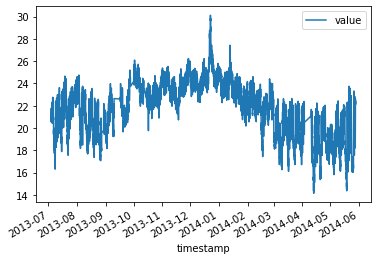

In [5]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

## 1.3 Feature engineering
Extracting some useful features

In [6]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [7]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [8]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay
0,2013-07-04 00:00:00,21.044908,0,0,3,1
1,2013-07-04 01:00:00,21.789015,1,0,3,1
2,2013-07-04 02:00:00,21.598781,2,0,3,1
3,2013-07-04 03:00:00,20.533000,3,0,3,1
4,2013-07-04 04:00:00,20.713084,4,0,3,1
...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1
7263,2014-05-28 12:00:00,22.318309,12,1,2,1
7264,2014-05-28 13:00:00,22.248092,13,1,2,1
7265,2014-05-28 14:00:00,22.125126,14,1,2,1


In [9]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

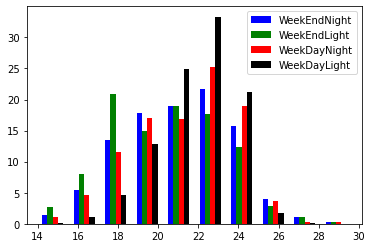

In [10]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

We can see that the temperature is more stable during daylight of business day.
# 2 Models
## 2.1 Cluster only
#### Use for collective anomalies (unordered). 

We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [16]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

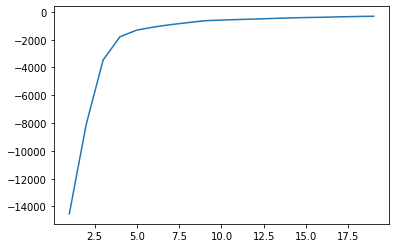

In [17]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [18]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

4     659
14    646
5     634
0     629
1     599
13    595
6     576
8     558
2     397
3     358
7     354
9     347
10    340
11    337
12    238
Name: cluster, dtype: int64

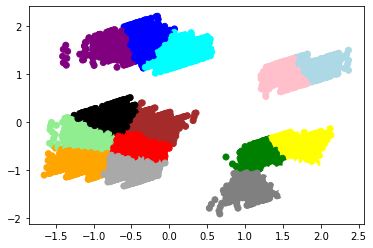

In [19]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [24]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [25]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/tmp/ipykernel_288599/4109955861.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


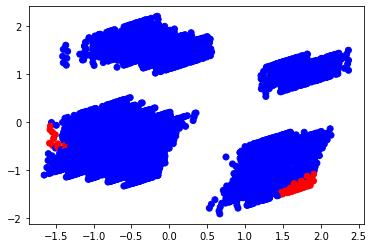

In [26]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

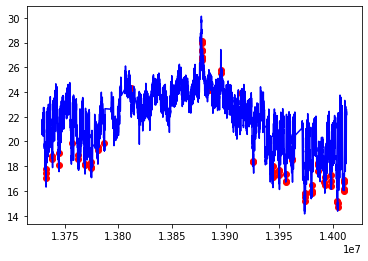

In [27]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

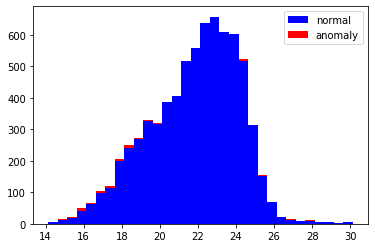

In [28]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.
## 2.2 Categories + Gaussian
#### Use for contextual data and collective anomalies (unordered).  
We will separate data by (what we think of) important categories. Or we can separate data based on different cluster (method 2.3). Then we find outliers (gaussian repartition, unimodal) by categories independently.   

In [29]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

<AxesSubplot:>

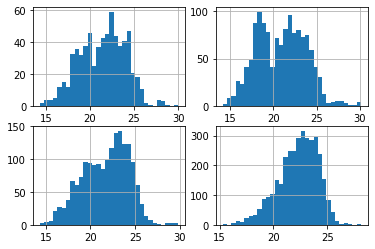

In [30]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [31]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

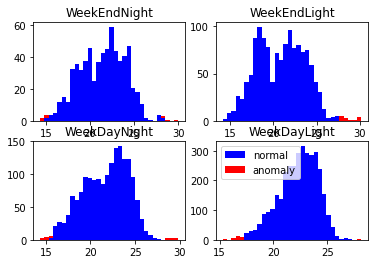

In [32]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [33]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

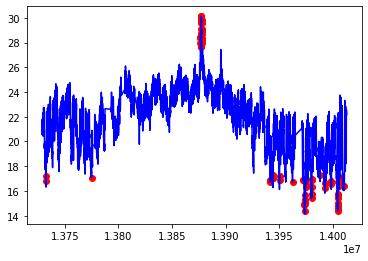

In [34]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

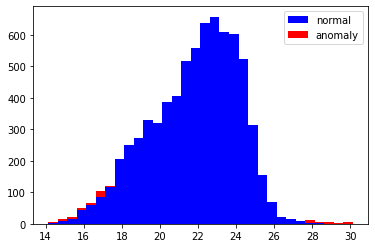

In [35]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Good detections of extreme values and context separation add some precision to the detection.
## 2.3 Cluster+Gaussian
Similar to 2.2 solution but with cluster to separate data in different group.

## 2.4 Markov chains
#### Use for  sequential anomalies (ordered)
We need discretize the data points in define states for markov chain. We will just take 'value' to define state for this example and define 5 levels of value (very low, low, average, high, very high)/(VL, L, A, H, VH).
Markov chain will calculate the probability of sequence like (VL, L, L, A, A, L, A). If the probability is very weak we consider the sequence as an anomaly.

In [36]:
# definition of the different state
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
# I USE pyemma NOT AVAILABLE IN KAGGLE KERNEL
#df_anomaly = markovAnomaly(df_mm, 5, 0.20)
#df_anomaly = pd.Series(df_anomaly)
#print(df_anomaly.value_counts())

In [28]:
"""
# add the data to the main 
df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()
"""

"\n# add the data to the main \ndf['anomaly24'] = df_anomaly\n\n# visualisation of anomaly throughout time (viz 1)\nfig, ax = plt.subplots()\n\na = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly\n\nax.plot(df['time_epoch'], df['value'], color='blue')\nax.scatter(a['time_epoch'],a['value'], color='red')\nplt.show()\n"

In [29]:
"""
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()
"""

"\n# visualisation of anomaly with temperature repartition (viz 2)\na = df.loc[df['anomaly24'] == 0, 'value']\nb = df.loc[df['anomaly24'] == 1, 'value']\n\nfig, axs = plt.subplots()\naxs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])\nplt.legend()\nplt.show()\n"

Detect unusual sequence but not extreme value. More difficult to evaluate the relevance on this example. The sequence size (5) should be match with some interesting cycle.
## 2.5 Isolation Forest
#### Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

In [11]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7195
1      72
Name: anomaly25, dtype: int64


In [14]:
df['anomaly25']

0       0
1       0
2       0
3       0
4       0
       ..
7262    0
7263    0
7264    0
7265    0
7266    0
Name: anomaly25, Length: 7267, dtype: int64

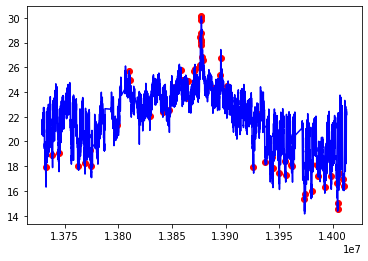

In [12]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

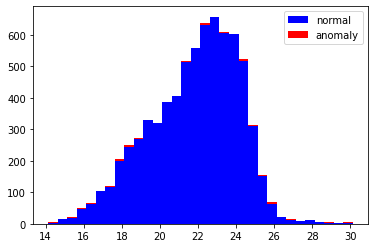

In [39]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## 2.6 One class SVM
#### Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [33]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


KeyError: 'anomaly26'

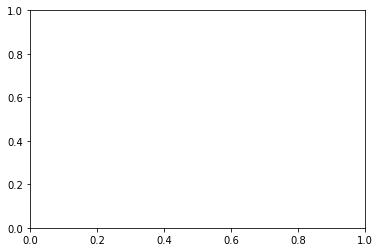

In [40]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

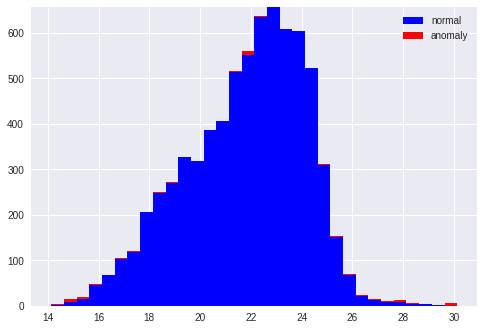

In [35]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Give result similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.
## 2.7 RNN
#### Use for  sequential anomalies (ordered)
RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.  
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [42]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [43]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [44]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

ModuleNotFoundError: No module named 'tensorflow'

In [39]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=50)`
  import sys


compilation time : 0.01883721351623535


In [40]:
# Train the model
#nb_epoch = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_split=0.1)


/opt/conda/lib/python3.6/site-packages/Keras-2.0.6-py3.6.egg/keras/models.py:846: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 5548 samples, validate on 617 samples
Epoch 1/30
5548/5548 [==============================] - 33s - loss: 0.7767 - val_loss: 0.8373
Epoch 2/30
5548/5548 [==============================] - 23s - loss: 0.3013 - val_loss: 0.4080
Epoch 3/30
5548/5548 [==============================] - 25s - loss: 0.2139 - val_loss: 0.3102
Epoch 4/30
5548/5548 [==============================] - 21s - loss: 0.1265 - val_loss: 0.2580
Epoch 5/30
5548/5548 [==============================] - 21s - loss: 0.1034 - val_loss: 0.2415
Epoch 6/30
5548/5548 [==============================] - 20s - loss: 0.1015 - val_loss: 0.2464
Epoch 7/30
5548/5548 [==============================] - 22s - loss: 0.1013 - val_loss: 0.2389
Epoch 8/30
5548/5548 [==============================] - 20s - loss: 0.1032 - val_loss: 0.2162
Epoch 9/30
5548/5548 [==============================] - 21s - loss: 0.1072 - val_loss: 0.1966
Epoch 10/30
5548/5548 [==============================] - 22s - loss: 0.0895 - val_loss: 0.1803
Epoch 11/30


In [41]:
# save the model because the training is long (1h30) and we don't want to do it every time
"""
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")
"""

'\n# serialize model to JSON\nmodel_json = model.to_json()\nwith open("model2.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model2.h5")\nprint("Saved model to disk")\n'

In [42]:
# load json and create model
"""
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
"""

'\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")\n'

In [43]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

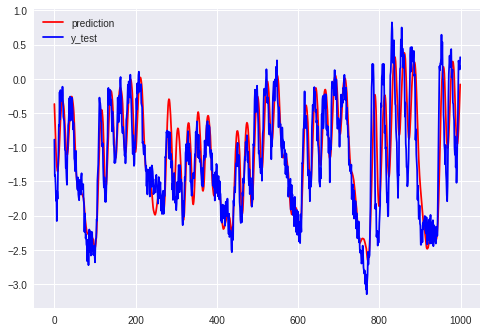

In [44]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [45]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


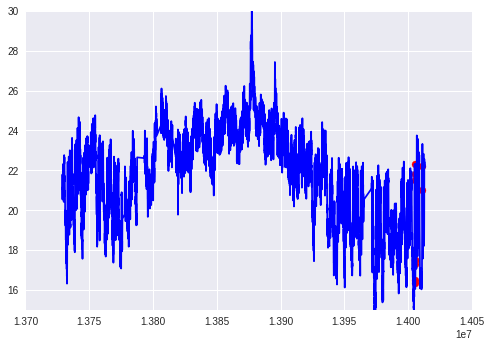

In [46]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


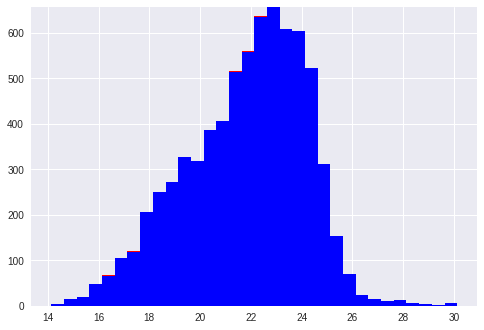

In [47]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## 2.8 Collective and sequential anomalies (Ordered)
This class is most general and consider ordering as well as value combinations. We usually use combination of algorithm like cluster+markov model.
## 3 Result comparison
(may be later)
## 4 Conclusion
For this case, the contextual anomaly detection (categories+elliptique enveloppe) seem a good solution. 